In [1]:
import os 
import json
import warnings

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

from sklearn.model_selection import ShuffleSplit, KFold


from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_1samp

from null_model import NullModel

In [2]:
%matplotlib inline
with open('../figures/.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))
    
pltdir = '../figures/'
data_dir = '../data'

# Load raw data

In [3]:
dataset = pd.read_csv(os.path.join(data_dir,'dataset.csv'), sep=',', index_col=0)

y = dataset.groupby('name').agg({'dG (kcal/mol)': 'first', 'testset': 'first'})


y_train = y.loc[y.testset==0]['dG (kcal/mol)']
y_test = y.loc[y.testset==1]['dG (kcal/mol)']

### vdW

X_vdw = pd.read_csv(os.path.join(data_dir, 'data_vdw_merged.csv'), sep=',', index_col=0)
X_vdw.drop(X_vdw.columns[np.max(X_vdw.loc[y_train.index], axis=0)>0.], axis=1, inplace=True)
X_vdw.drop(X_vdw.columns[np.mean(np.abs(X_vdw.loc[y_train.index]),axis=0)<0.1], axis=1, inplace=True)


### RMS

X_rms = pd.read_csv(os.path.join(data_dir, 'data_rms_merged.csv'), sep=',', index_col=0)

### Torsion

X_torsion = pd.read_csv(os.path.join(data_dir, 'data_torsion_merged.csv'), sep=',', index_col=0)
X_torsion.dropna(axis=1, inplace=True)
chi = []
for c in X_torsion.columns:
    if c.split(':')[2][:3] == 'Chi':
        chi.append(c)
X_torsion.drop(chi, axis=1, inplace=True)

### HBond

X_hbond = pd.read_csv(os.path.join(data_dir, 'data_hbond_merged.csv'), sep=',', index_col=0)
X_hbond.dropna(axis=1, inplace=True)
X_hbond.drop(X_hbond.columns[X_hbond.sum(axis=0)<=0.], axis=1, inplace=True)

X_hbond.loc[:,'flaps_water'] = X_hbond.loc[:, ['1:L:A:1:50:O:H','1:L:B:1:50:O:H']].sum(axis=1)
X_hbond.loc[:,'D25'] = X_hbond.loc[:, ['0:A:L:25:1:OS:H', '0:B:L:25:1:OS:H', '0:L:B:1:25:O:HD2', '0:L:A:1:25:O:HD2']].sum(axis=1)
X_hbond.drop(['1:L:A:1:50:O:H', '1:L:B:1:50:O:H', '0:A:L:25:1:OS:H', '0:B:L:25:1:OS:H',
              '0:L:B:1:25:O:HD2', '0:L:A:1:25:O:HD2'], axis=1, inplace=True)

### Sequence

sequence = pd.read_csv(os.path.join(data_dir, 'aa_sequence.csv'), sep=',', index_col=0)
X_mut = (sequence == sequence.loc['NL4-3']).astype(int)

# Split into train and testset
X_mut_train = X_mut.loc[y_train.index]
X_mut.drop(X_mut_train.columns[X_mut_train.sum(axis=0)==X_mut_train.shape[0]], axis=1, inplace=True)

### Merge

X = pd.concat([X_vdw, X_rms, X_torsion, X_hbond, X_mut], axis=1, sort=False)
X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

# Fit model selecting features agains null model

## Define specificity tests

In [5]:
tests = {}

for c in X_vdw.columns:
    r1, r2 = c.split(' - ')
    if 'LIG' in [r1, r2]:
        continue
        
    resnum1 = r1.split(':')[0]
    if resnum1 in X_mut:
        tests[c] = [resnum1,]
    resnum2 = r2.split(':')[0]
    if resnum2 in X_mut:
        if c not in tests:
            tests[c] = [resnum2,]
        else:
            tests[c].append(resnum2)  

N = len(tests)
print('{} tests for vdw'.format(N))

for c in X_rms.columns:
    if c == 'mean_rmsd':
        continue
    
    chain, resnum = c.split(':')
    if chain == 'LIG':
        continue
        
    if resnum in X_mut:
        tests[c] = [resnum,]

print('{} tests for rms'.format(len(tests)-N))
N = len(tests)

for c in X_torsion.columns:
    if c.split(':')[0] == 'LIG':
        continue
    resnum, chain, tt = c.split(':')
    if resnum in X_mut:
        tests[c] = [resnum,]

print('{} tests for torsion'.format(len(tests)-N))
N = len(tests)

for c in X_hbond.columns:
    if c in ['D25', 'flaps_water']:
        continue
    ht, c1, c2, r1, r2, atm1, atm2 = c.split(':')
    if 'L' in [c1, c2]:
        continue
    if r1 in X_mut:
        tests[c] = [r1, ]
    if r2 in X_mut:
        if c in tests:
            tests[c].append(r2)
        else:
            tests[c] = [r2, ]
                    
print('{} tests for hbond'.format(len(tests)-N))
N = len(tests)

print('{} tests in total'.format(N))

657 tests for vdw
54 tests for rms
108 tests for torsion
275 tests for hbond
1094 tests in total


## How many features would be rejected based on the Null Model

In [6]:
nm = NullModel(tests=tests, p=0.05, drop_null=True)
nm.fit(X_train, y_train)
# Get all features for which p>0.05, subtracting sequence (null model) feature 
print('{} features rejected by null model'.format((nm.support>0.05).sum()-X_mut_train.shape[1]))

/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


987 features rejected by null model


## Coefficient Filtering

In [7]:
x_train = X_train

splits = 100
cv = ShuffleSplit(n_splits=splits, test_size=1/3, random_state=42)
coefs = pd.DataFrame(np.zeros((X_train.shape[1], splits)), 
                    index=X_train.columns, columns=np.arange(splits))


reg = Pipeline([('nm', NullModel(tests=tests, p=0.05, drop_null=True)),
                ('scale', StandardScaler()),
                ('en', ElasticNet(l1_ratio=0.75, alpha=1))])

mse = []
predictions = pd.Series(index=y_train.index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i,(tindex, vindex) in enumerate(cv.split(x_train)):
        Xt, Xv, yt, yv = x_train.iloc[tindex], x_train.iloc[vindex], y_train.iloc[tindex], y_train.iloc[vindex]
        reg.fit(Xt, yt)
        yv_hat = reg.predict(Xv)
        predictions.iloc[vindex] = yv_hat
        mse.append(mean_squared_error(yv_hat, yv))
        if mse[-1] <= 9.:
            coef_index = reg.steps[0][1].transform(X_train).columns[np.abs((reg.steps[2][1].coef_))>0.]
            coef_val = reg.steps[2][1].coef_[np.abs((reg.steps[2][1].coef_))>0.]
            coefs.loc[coef_index, i] = coef_val
        print('{}; current: {:.2f} mean: {:.2f}'.format(i,np.sqrt(mse[-1]), np.mean(np.sqrt(mse))))

0; current: 1.89 mean: 1.89
1; current: 1.88 mean: 1.88
2; current: 1.90 mean: 1.89
3; current: 1.53 mean: 1.80
4; current: 2.84 mean: 2.01
5; current: 1.63 mean: 1.94
6; current: 1.89 mean: 1.94
7; current: 1.77 mean: 1.92
8; current: 1.38 mean: 1.86
9; current: 1.55 mean: 1.83
10; current: 2.58 mean: 1.89
11; current: 1.50 mean: 1.86
12; current: 1.72 mean: 1.85
13; current: 1.81 mean: 1.85
14; current: 1.83 mean: 1.85
15; current: 2.24 mean: 1.87
16; current: 1.96 mean: 1.88
17; current: 2.12 mean: 1.89
18; current: 2.23 mean: 1.91
19; current: 1.36 mean: 1.88
20; current: 2.01 mean: 1.89
21; current: 1.66 mean: 1.88
22; current: 1.91 mean: 1.88
23; current: 1.61 mean: 1.87
24; current: 1.46 mean: 1.85
25; current: 2.05 mean: 1.86
26; current: 2.20 mean: 1.87
27; current: 1.67 mean: 1.86
28; current: 1.77 mean: 1.86
29; current: 2.66 mean: 1.89
30; current: 0.98 mean: 1.86
31; current: 1.77 mean: 1.85
32; current: 1.36 mean: 1.84
33; current: 2.17 mean: 1.85
34; current: 2.09 mean: 

In [8]:
coefs.drop(coefs.index[coefs.sum(axis=1)==0], inplace=True)
coefs.drop(coefs.columns[coefs.sum(axis=0)==0], inplace=True, axis=1)

In [9]:
p_values = pd.Series(index=coefs.index)

for index in coefs.index:
    p_values[index] = ttest_1samp(coefs.loc[index], 0)[1]
       

In [10]:
print('Non-zero coefficients: {}'.format((p_values<=0.05).sum()))
coefs_nonzero = coefs.drop(p_values.index[p_values>0.05]).mean(axis=1)

Non-zero coefficients: 58


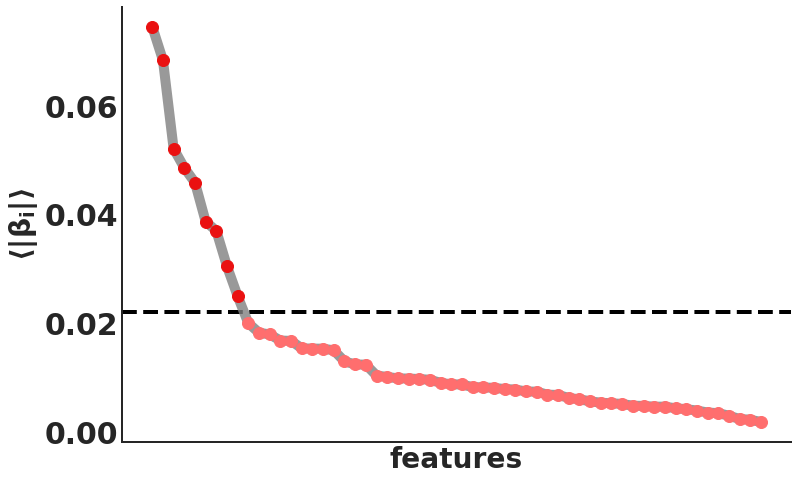

In [11]:
sns.set_style('white')

plt.figure(figsize=(12,8))

ax = plt.subplot(1, 1, 1)

ax.plot(coefs_nonzero.abs().sort_values(ascending=False), lw=10, zorder=10, c='Gray', alpha=0.8)

ax.plot(coefs_nonzero.abs().sort_values(ascending=False).loc[coefs_nonzero.index[coefs_nonzero.abs()>=0.02]],
        'o', ms=12, zorder=100, c='#EA1111')
ax.plot(coefs_nonzero.abs().sort_values(ascending=False).loc[coefs_nonzero.index[coefs_nonzero.abs()<0.02]],
        'o', ms=12, zorder=100, c='#FF6E6E')
ax.axhline(0.022, ls='--', lw=4, c='k', zorder=1)
ax.set_ylabel('$\\rm \\bf \\langle | \\beta_{i} | \\rangle$')
ax.set_xlabel('features')
ax.set_xticks([])
ax.set_xticklabels([])
for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)
plt.savefig(os.path.join(pltdir, 'feature_selection_curve.png'), dpi=300, bbox_inches = 'tight')
plt.show()

In [12]:
coefs_nonzero.abs().sort_values(ascending=False).to_csv(os.path.join(pltdir, 'nonzero_coef.csv'))

/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### Pairplot features

In [13]:
top_coef = coefs_nonzero.index[coefs_nonzero.abs()>0.02]
x_train = X_train[top_coef]
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scale  = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_train_scale_nice = x_train_scale.rename(mapper={'10:B - 24:B': '$\\rm vdW\ 10_{B}-24_{B}$',
                             '12:B - 13:B': '$\\rm vdW\ 12_{B}-13_{B}$',
                            '50:B - 84:A': '$\\rm vdW\ 50_{B}-84_{A}$',
                            '54:A - 56:A': '$\\rm vdW\ 54_{A}-56_{A}$',
                            '80:A - 84:A': '$\\rm vdW\ 80_{A}-84_{A}$',
                            'LIG:12': '$\\rm RMSF\ DRV_{12}$',
                             '45:A:Psi': '$\\rm 45_{A}\ \\Psi$',
                             '92:B:Psi': '$\\rm 92_{B}\ \\Psi$',
                            'D25': '$\\rm HBond\ D25$'}, axis=1)

### Feature colinearity

<Figure size 1296x1296 with 0 Axes>

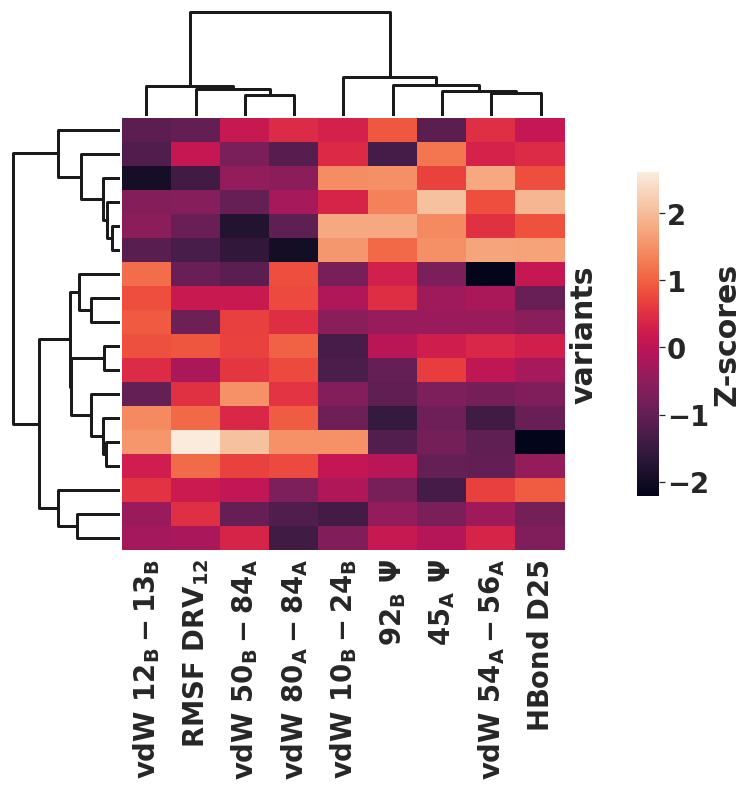

In [14]:
font = {'weight' : 'bold',
        'size'   : 48}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **{'labelweight': 'bold'})
matplotlib.rc('xtick', **{'labelsize': 40})
matplotlib.rc('ytick', **{'labelsize': 40})
matplotlib.rc('lines', **{'linewidth': 10})
sns.set(font_scale=2.5)

x_train_scale_nice.rename({'12:B - 13:B': '$\\rm 12_{B}-13_{B}$'},)

plt.figure(figsize=(18, 18))
cbar_kws = {'drawedges':False, 
            'label':'Z-scores',}
g = sns.clustermap(x_train_scale_nice, metric='correlation', cbar_kws=cbar_kws,)


for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(3)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(3)

#g.cax.set_visible(False)

ax = g.ax_heatmap

g.cax.set_position([1., .2, .03, .45])

ax.set_yticks([])
ax.set_ylabel('variants')

plt.savefig(os.path.join(pltdir, 'feature_selection_clustermap.png'), dpi=300, bbox_inches = 'tight')
plt.show()

### Pairplot

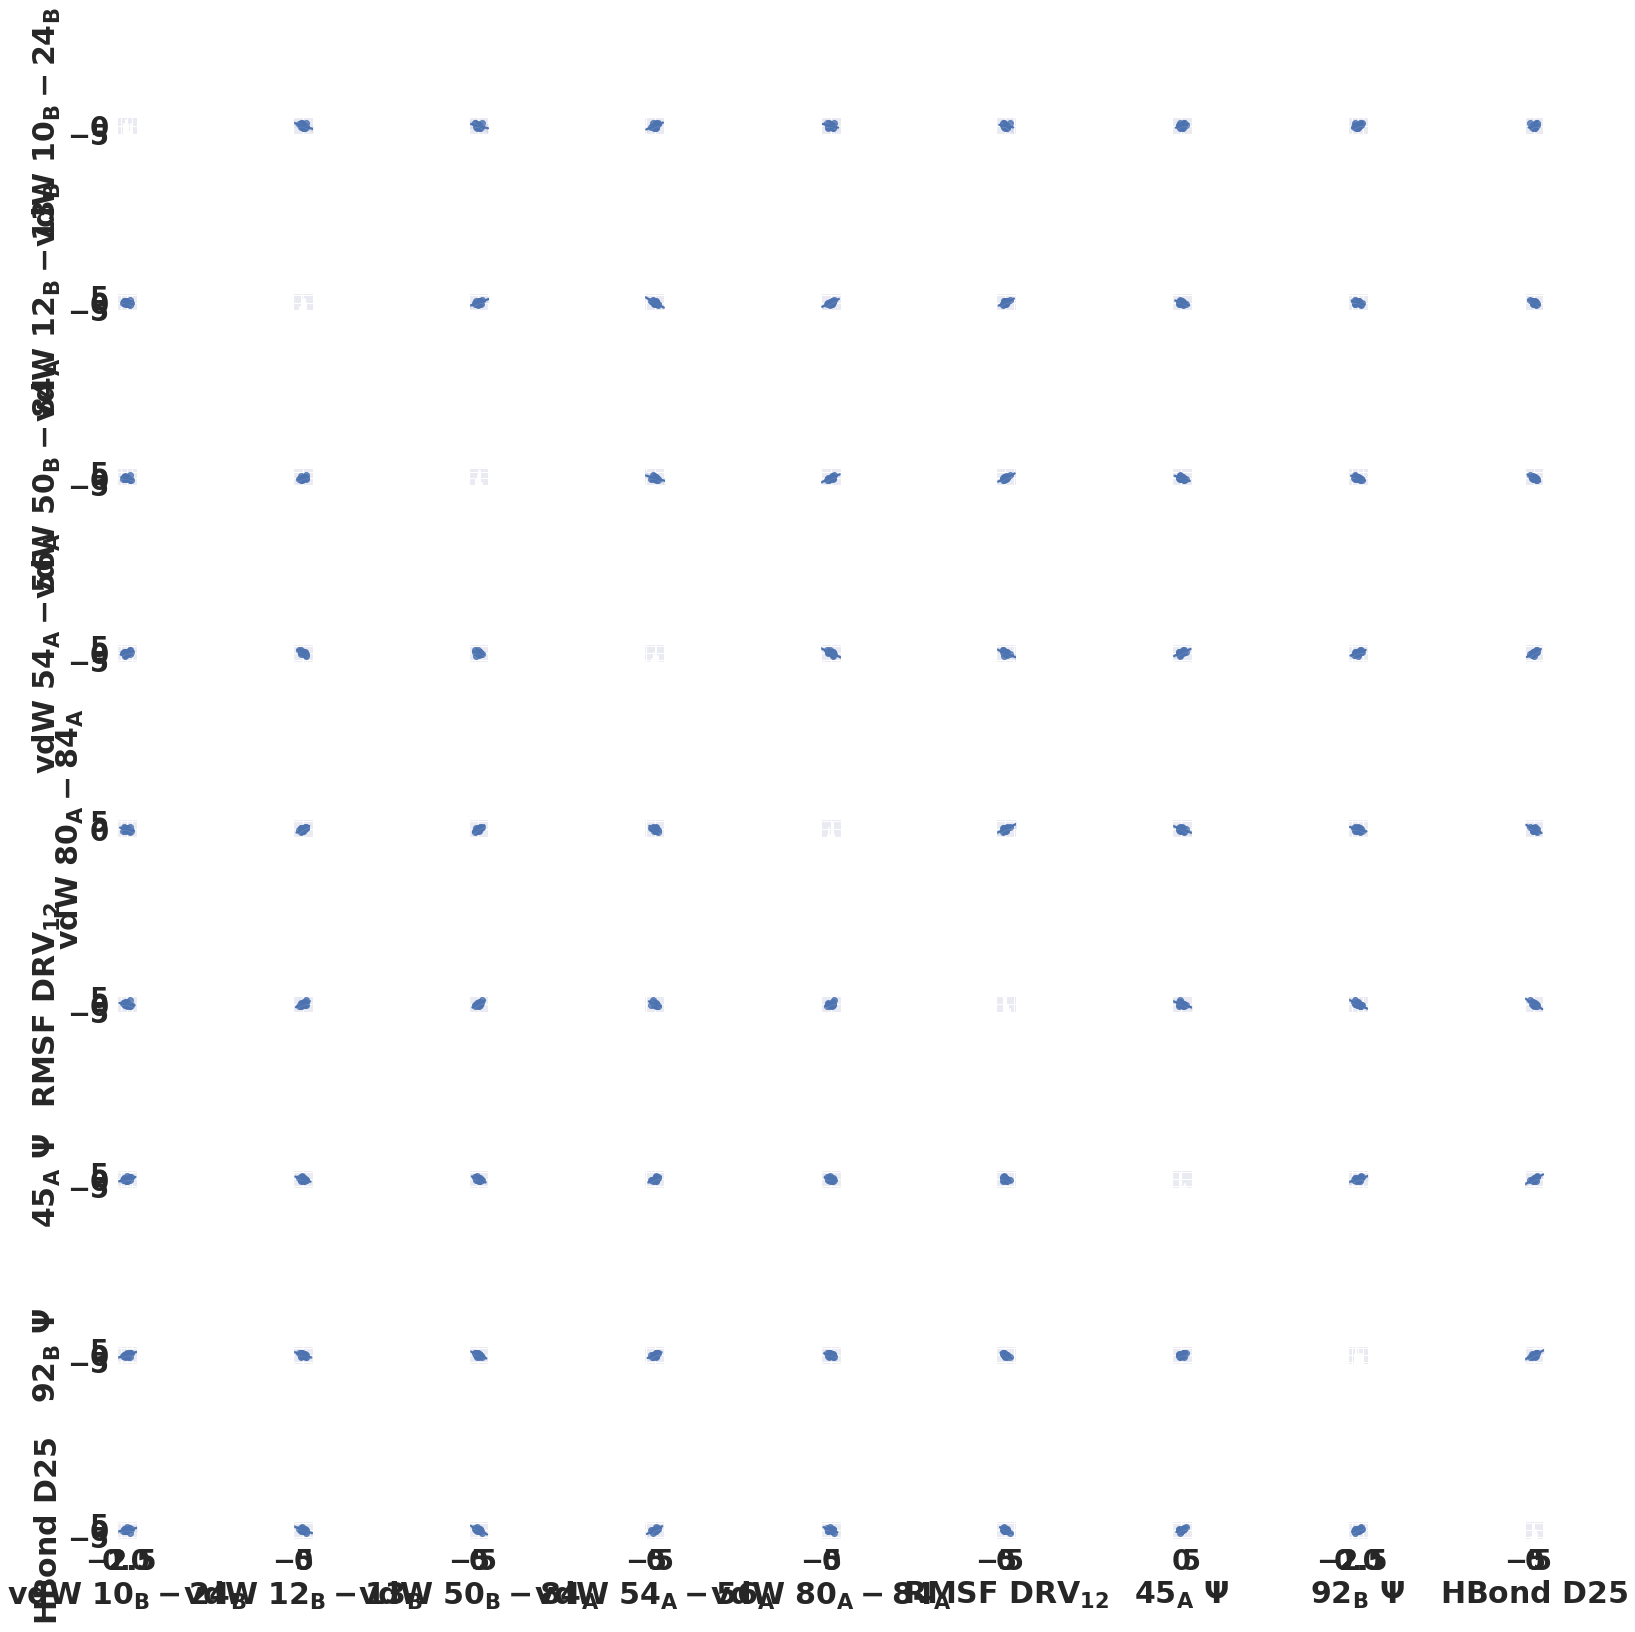

In [20]:
#plt.figure(figsize=(16, 16))
sns.pairplot(x_train_scale_nice, kind='reg')
plt.savefig(os.path.join(pltdir, 'feature_selection_pairplot.png'), dpi=300, bbox_inches = 'tight')

## Swap symmetry related features

In [16]:
import copy

relative_likelihood = lambda x, x_min: np.exp((x_min-x)/2)

pred_coef = list(coefs_nonzero.index[coefs_nonzero.abs()>=0.02])

swap = [(0, '10:A - 24:A'), (1, '12:A - 13:A'), (2, '50:A - 84:B'),
        (3, '54:B - 56:B'), (4, '80:B - 84:B'), (6, '45:B:Psi'),
        (7, '92:A:Psi')]

m = sm.OLS(y_train, sm.add_constant(x_train_scale[pred_coef])).fit()

for s in swap:
    scaler = StandardScaler()
    coef_tmp = copy.copy(pred_coef)
    coef_tmp[s[0]] = s[1]
    m_sym = sm.OLS(y_train, sm.add_constant(scaler.fit_transform(X_train[coef_tmp]))).fit()
    if m_sym.aic < m.aic:
        rll = relative_likelihood(m.aic, m_sym.aic)
        if rll>0.05:
            print('swaping {} for {} did not significantly decrease model performance'.format(s[1], pred_coef[s[0]]))
        else:
            print('swaping {} for {} improved the model'.format(s[1], pred_coef[s[0]]))
    else:
        rll = relative_likelihood(m_sym.aic, m.aic)
        if rll>0.05:
            print('swaping {} for {} did not significantly decrease model performance'.format(s[1], pred_coef[s[0]]))
    

swaping 50:A - 84:B for 50:B - 84:A did not significantly decrease model performance
swaping 54:B - 56:B for 54:A - 56:A did not significantly decrease model performance
swaping 80:B - 84:B for 80:A - 84:A did not significantly decrease model performance
swaping 45:B:Psi for 45:A:Psi did not significantly decrease model performance
swaping 92:A:Psi for 92:B:Psi did not significantly decrease model performance


/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Swapping all features

In [17]:
pred_coef = list(coefs_nonzero.index[coefs_nonzero.abs()>=0.02])
scaler = StandardScaler()
m = sm.OLS(y_train, sm.add_constant(x_train_scale[pred_coef])).fit()
m_sym = sm.OLS(y_train, sm.add_constant(scaler.fit_transform(X_train[['10:A - 24:A', '12:A - 13:A', '50:A - 84:B',
                                                                  '54:B - 56:B', '80:B - 84:B', '45:B:Psi', 
                                                                  '92:A:Psi', 'D25', 'LIG:12']]))).fit()

if m_sym.aic < m.aic:
    rll = relative_likelihood(m.aic, m_sym.aic)
    if rll>0.05:
        print('swaping all features did not significantly decrease model performance')
    else:
        print('swaping all features did improved the model')
else:
    rll = relative_likelihood(m_sym.aic, m.aic)
    if rll>0.05:
        print('swaping all features did not significantly decrease model performance')
    else:
        print('swapping all features did significantly decrease model performance\n rlh: {:.3f}'.format(rll))
        print('Model R2:{:.2f}\n Symmetry swapped R2:{:.2f}'.format(m.rsquared, m_sym.rsquared))


swapping all features did significantly decrease model performance
 rlh: 0.018
Model R2:0.96
 Symmetry swapped R2:0.93


/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Brute Force find the model with the best fit including up to 9 parameters

In [18]:
from itertools import combinations

pred_coef = list(coefs_nonzero.index[coefs_nonzero.abs()>=0.02])
results_df = pd.DataFrame(columns=pred_coef+['rsquared', 'aic'])
r_max = 9
i = 0
for r in range(1, r_max+1):
    for c in combinations(pred_coef, r):
        x_eval = StandardScaler().fit_transform(X_train[list(c)])
        m = sm.OLS(y_train, sm.add_constant(x_eval)).fit()
        results_df.loc[i, list(c)] = True
        results_df.loc[i, 'rsquared'] = m.rsquared
        results_df.loc[i, 'aic'] = m.aic
        results_df.loc[i, 'df'] = m.df_model
        i += 1
        
relative_likelihood = lambda x, x_min: np.exp((x_min-x)/2)
aic_min = results_df.aic.min()
for index, aic in zip(results_df.index, results_df.aic):
    results_df.loc[index, 'rlh'] = relative_likelihood(aic, aic_min)

print(results_df[(results_df.rlh>0.05) & (results_df.df<=4)].sort_values('rsquared', ascending=False))

    10:B - 24:B 12:B - 13:B 50:B - 84:A 54:A - 56:A 80:A - 84:A LIG:12  \
134        True        True        True         NaN         NaN    NaN   
131        True        True        True         NaN         NaN   True   
129        True        True        True        True         NaN    NaN   
144        True        True         NaN         NaN         NaN   True   
146        True        True         NaN         NaN         NaN   True   

    45:A:Psi 92:B:Psi   D25  rsquared      aic   df       rlh  
134      NaN      NaN  True  0.920023  40.2361  4.0  0.108027  
131      NaN      NaN   NaN   0.91899  40.4671  4.0  0.096243  
129      NaN      NaN   NaN  0.918688   40.534  4.0  0.093079  
144     True      NaN   NaN  0.917944  40.6979  4.0  0.085756  
146      NaN      NaN  True  0.917008  40.9021  4.0  0.077431  


In [21]:
results_df[(results_df.rlh>0.05) & (results_df.df<=4)].sort_values('rsquared', ascending=False)

,10:B - 24:B,12:B - 13:B,50:B - 84:A,54:A - 56:A,80:A - 84:A,LIG:12,45:A:Psi,92:B:Psi,D25,rsquared,aic,df,rlh
134,True,True,True,NaN,NaN,NaN,NaN,NaN,True,0.920023,40.2361,4.0,0.108027
131,True,True,True,NaN,NaN,True,NaN,NaN,NaN,0.91899,40.4671,4.0,0.096243
129,True,True,True,True,NaN,NaN,NaN,NaN,NaN,0.918688,40.534,4.0,0.093079
144,True,True,NaN,NaN,NaN,True,True,NaN,NaN,0.917944,40.6979,4.0,0.085756
146,True,True,NaN,NaN,NaN,True,NaN,NaN,True,0.917008,40.9021,4.0,0.077431


0 0.6375755444416028 0.6375755444416028
1 0.6853483931649322 0.6614619688032675
2 0.9274489092719242 0.7501242822928198
3 1.5461157046782064 0.9491221378891664
4 0.7643621037299413 0.9121701310573215


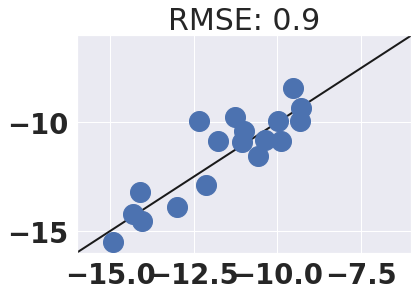

In [22]:
x = X[['10:B - 24:B', '12:B - 13:B', '50:B - 84:A', 'D25']]
x_train = x.loc[y_train.index]
x_test = x.loc[y_test.index]

cv =KFold(n_splits=5)
clf = Pipeline([('scale', StandardScaler()),
                ('ols', LinearRegression())])

mse = []
predictions = pd.Series(index=y_train.index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i,(tindex, vindex) in enumerate(cv.split(x_train)):
        Xt, Xv, yt, yv = x_train.iloc[tindex], x_train.iloc[vindex], y_train.iloc[tindex], y_train.iloc[vindex]
        clf.fit(Xt, yt)
        yv_hat = clf.predict(Xv)
        predictions.iloc[vindex] = yv_hat
        mse.append(mean_squared_error(yv_hat, yv))
        print(i,np.sqrt(mse[-1]), np.mean(np.sqrt(mse)))

plt.plot(predictions, y_train, 'o', ms=20, zorder=10)
plt.title('RMSE: {:.1f}'.format(np.mean(np.sqrt(mse))))
lim = (-16, -6)
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, lim, lw=2, c='k', zorder=1)

In [23]:
pearsonr(predictions, y_train)

(0.8825062209194147, 1.25534525013323e-06)

In [24]:
spearmanr(predictions, y_train)

SpearmanrResult(correlation=0.780588643001674, pvalue=0.0001320858238899891)

In [25]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scale  = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test_scale = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

m = sm.OLS(y_train, sm.add_constant(x_train_scale)).fit()
m.summary()

/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          dG (kcal/mol)   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     37.39
Date:                Fri, 28 Feb 2020   Prob (F-statistic):           5.17e-07
Time:                        11:55:51   Log-Likelihood:                -15.118
No. Observations:                  18   AIC:                             40.24
Df Residuals:                      13   BIC:                             44.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -11.4991      0.155    -73.980      0.000     -11.835     -11.163
10:B - 24:B    -0.5838      0.172     -3.390      0.005      -0.956      -0.212
12:B - 13:B     0.7313      0.196      3.724      0.003       0.307       1.156
50:B - 84:A     0.5933      0.227      2.618      0.021       0.104       1.083
D25            -0.5537      0.244     -2.273      0.041      -1.080      -0.027
==============================================================================
Omnibus:                        0.516   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.604
Skew:                           0.240   Prob(JB):                        0.739
Kurtosis:                       2.241   Cond. No.                         3.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
def plot_ols(model, x, y, **kwargs):
    yhat = m.predict(sm.add_constant(x))
    yerr1 = ((sm.add_constant(x)@m.conf_int()[0].values) - yhat).values
    yerr2 = ((sm.add_constant(x)@m.conf_int()[1].values) - yhat).values
    yerr = np.zeros((2, len(y)))

    # matplotlib errorbar takes only positive values
    for i,(e1, e2) in enumerate(zip(yerr1, yerr2)):
        if e1 >= 0 :
            yerr[1][i] = e1
        else:
            yerr[0][i] = np.abs(e1)
        if e2 >= 0 :
            yerr[1][i] = e2
        else:
            yerr[0][i] = np.abs(e2)
    return  plt.errorbar(y, yhat, yerr=yerr, **kwargs)

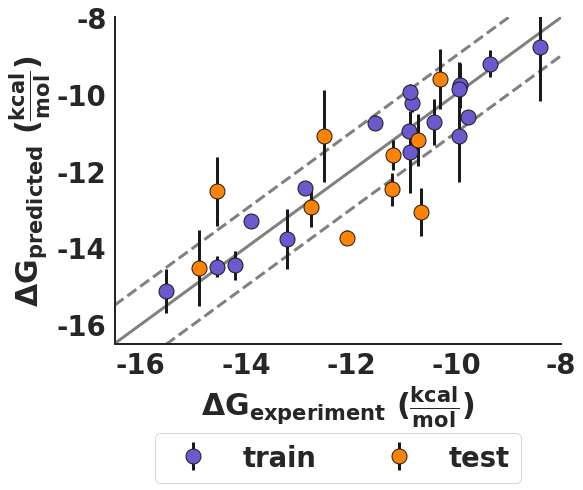

In [27]:
sns.set_style("white")
lim = np.array([-16.5, -8])

plt.figure(figsize=(8, 6))

ax = plt.subplot(1, 1, 1)

e1 = plot_ols(m, x_train_scale, y_train, fmt='o', ms=15, lw=3, c='#6A5ACD', markeredgecolor='k', ecolor='k',
              label='train', zorder=100)
e2 = plot_ols(m, x_test_scale, y_test, fmt='o', ms=15, lw=3, c='#FF8300', markeredgecolor='k', ecolor='k',
              label='test', zorder=100)

plt.plot(lim, lim, lw=3, ls='-', c='Gray', zorder=1)
plt.plot(lim, lim+np.ones(2), lw=3, ls='--', c='Gray', zorder=1)
plt.plot(lim, lim-np.ones(2), lw=3, ls='--', c='Gray', zorder=1)
plt.xlim(lim)
plt.xlabel('$\\rm \\bf \\Delta G_{experiment}\ (\\frac{kcal}{mol})$')
plt.ylabel('$\\rm \\bf \\Delta G_{predicted}\ (\\frac{kcal}{mol})$')

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)

plt.xticks(list(range(-16, -6, 2)), list(map(str, list(range(-16, -6, 2)))))
plt.yticks(list(range(-16, -6, 2)), list(map(str, list(range(-16, -6, 2)))))
plt.ylim(lim)
plt.xlim(lim)
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='center', borderaxespad=0., ncol=2)
#plt.title('Sparse Model')
plt.savefig(os.path.join(pltdir, 'regression_model.png'), dpi=300, bbox_inches = 'tight')
plt.show()

In [28]:
yhat = m.predict(sm.add_constant(x_test_scale))

In [29]:
np.sqrt(mean_squared_error(yhat, y_test))

1.3154069702581053

In [30]:
pearsonr(yhat, y_test)

(0.5972876849361585, 0.06825523702277153)

In [31]:
spearmanr(yhat, y_test)

SpearmanrResult(correlation=0.5151515151515151, pvalue=0.12755286970323426)

### Individual datapoints

/home/leidnerf/schrodinger.ve/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


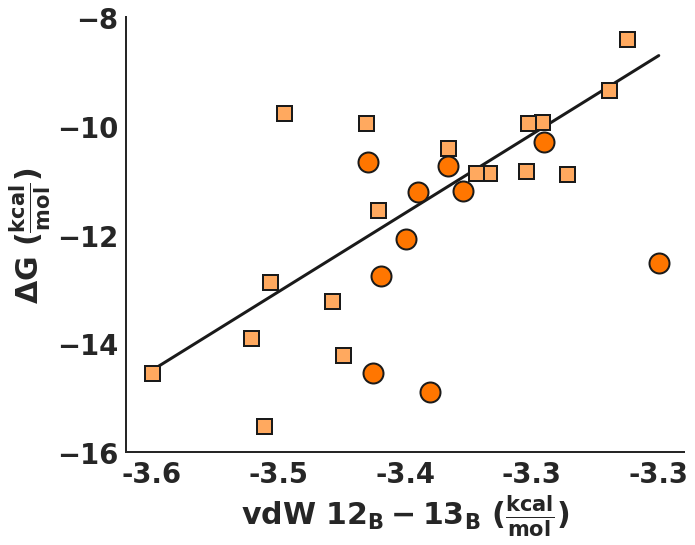

In [33]:
feat = '12:B - 13:B'
plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plt.plot(X_train['12:B - 13:B'], y_train, 's', c='#FFA95F', markeredgecolor='k', mew=2, ms=15, label='train', zorder=100)
plt.plot(X_test['12:B - 13:B'], y_test, 'o', c='#FF7600', markeredgecolor='k', mew=2, ms=20, label='train', zorder=100)

feat = '12:B - 13:B'
fm = sm.OLS(y_train, sm.add_constant(X_train[feat])).fit()
xmin = X[feat].min()
xmax = X[feat].max()
pmin = fm.params['const']+fm.params[feat]*xmin
pmax = fm.params['const']+fm.params[feat]*xmax
plt.plot([xmin, xmax], [pmin, pmax], lw=3, c='k')


plt.xlabel('$\\rm \\bf vdW\ 12_{B}-13_{B}\ (\\frac{kcal}{mol}$)')
plt.ylabel('$\\rm \\bf \\Delta G\ (\\frac{kcal}{mol})$')
plt.ylim((-16, -8))

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)

    
ax.xaxis.set_ticks(np.linspace(X[feat].min(), X[feat].max() ,5))
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))

plt.savefig(os.path.join(pltdir, 'vdw_12B-13B_regression.png'), dpi=300, bbox_inches = 'tight')
plt.show()

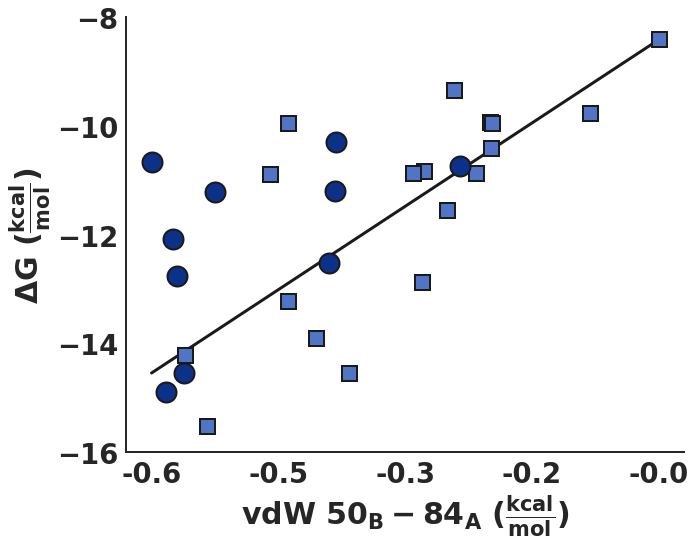

In [34]:
feat = '50:B - 84:A'
plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)
plt.plot(X_train['50:B - 84:A'], y_train, 's', c='#5174C5', markeredgecolor='k', mew=2, ms=15, label='train', zorder=100)
plt.plot(X_test['50:B - 84:A'], y_test, 'o', c='#0B3188', markeredgecolor='k', mew=2, ms=20, label='train', zorder=100)
plt.xlabel('$\\rm \\bf vdW\ 50_{B}-84_{A}\ (\\frac{kcal}{mol}$)')
plt.ylabel('$\\rm \\bf \\Delta G\ (\\frac{kcal}{mol})$')
plt.ylim((-16, -8))

fm = sm.OLS(y_train, sm.add_constant(X_train[feat])).fit()
xmin = X[feat].min()
xmax = X[feat].max()
pmin = fm.params['const']+fm.params[feat]*xmin
pmax = fm.params['const']+fm.params[feat]*xmax
plt.plot([xmin, xmax], [pmin, pmax], lw=3, c='k')

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)
    
ax.xaxis.set_ticks(np.linspace(X[feat].min(), X[feat].max() ,5))
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))

plt.savefig(os.path.join(pltdir, 'vdw_50B-84A_regression.png'), dpi=300, bbox_inches = 'tight')
plt.show()

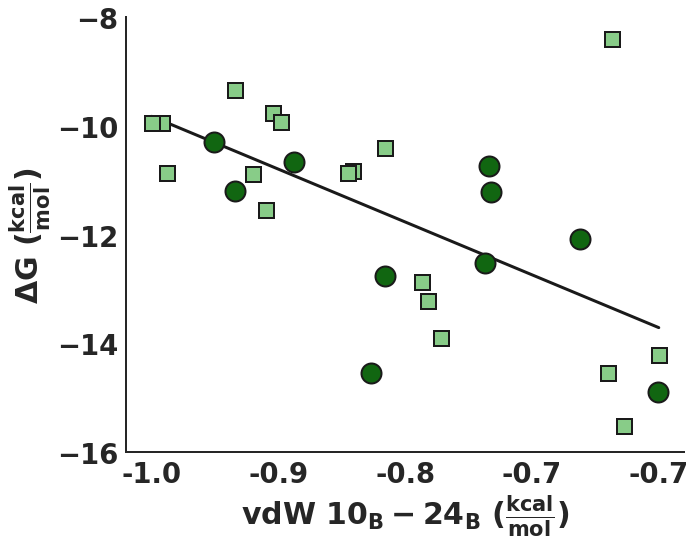

In [35]:
feat = '10:B - 24:B'
plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plt.plot(X_train[feat], y_train, 's', c='#88CC88', mec='k', mew=2, ms=15, label='train', zorder=100)
plt.plot(X_test[feat], y_test, 'o', c='#116611', mec='k', mew=2, ms=20, label='train', zorder=100)
plt.xlabel('$\\rm \\bf vdW\ 10_{B}-24_{B}\ (\\frac{kcal}{mol}$)')
plt.ylabel('$\\rm \\bf \\Delta G\ (\\frac{kcal}{mol})$')
plt.ylim((-16, -8))

fm = sm.OLS(y_train, sm.add_constant(X_train[feat])).fit()
xmin = X[feat].min()
xmax = X[feat].max()
pmin = fm.params['const']+fm.params[feat]*xmin
pmax = fm.params['const']+fm.params[feat]*xmax
plt.plot([xmin, xmax], [pmin, pmax], lw=3, c='k')

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_ticks(np.linspace(X[feat].min(), X[feat].max() ,5))
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))

plt.savefig(os.path.join(pltdir, 'vdw_10B-24B_regression.png'), dpi=300, bbox_inches = 'tight')
plt.show()

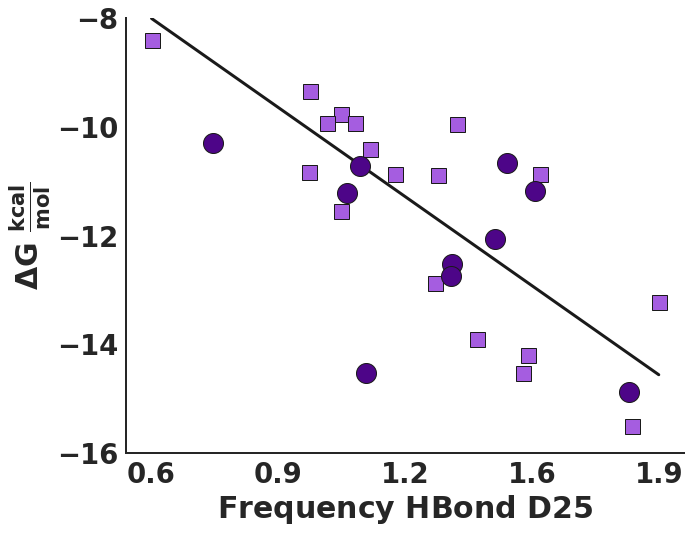

In [36]:
feat = 'D25'
plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1)
plt.plot(X_train['D25'], y_train, 's', c='#A55DE0', markeredgecolor='k', ms=15, label='train', zorder=100)
plt.plot(X_test['D25'], y_test, 'o', c='#4D0588', markeredgecolor='k', ms=20, label='train', zorder=100)
plt.xlabel('$\\rm \\bfFrequency\ HBond\ D25$')
plt.ylabel('$\\rm \\bf \\Delta G\ \\frac{kcal}{mol}$')
plt.ylim((-16, -8))

fm = sm.OLS(y_train, sm.add_constant(X_train[feat])).fit()
xmin = X[feat].min()
xmax = X[feat].max()
pmin = fm.params['const']+fm.params[feat]*xmin
pmax = fm.params['const']+fm.params[feat]*xmax
plt.plot([xmin, xmax], [pmin, pmax], lw=3, c='k')

for axis in ['top','bottom','left','right']:
    if axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_ticks(np.linspace(X[feat].min(), X[feat].max() ,5))
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.1f'))

plt.savefig(os.path.join(pltdir, 'hbond_D25_regression.png'), dpi=300, bbox_inches = 'tight')
plt.show()